# Orbit Diagrams, Surfaces of Section
In this tutorial we will be using a `DynamicalSystem` instance to visualize aspects of the system.

Topics:
* `orbitdiagram`
* `poincaresos`
* `produce_orbitdiagram`
* Docstrings

# Orbit Diagram
An "orbit diagram" is simply a plot that shows the long term behavior of a discrete system when a parameter is varied. Most of the time you want to evolve the system for a transient amount of time, and then start recording its state.

This is exactly what the function `orbitdiagram` does:
1. Evolves the system for a transient amount of time.
2. Saves the output of the system for a chosen variable.
3. Changes/increments a parameter of the equations of motion.
4. Repeat steps 1-3 for all given parameter values!

This approach is also related with the (much more advanced) [sensitivity analysis](http://docs.juliadiffeq.org/latest/analysis/sensitivity.html) from DifferentialEquations.jl

---

Let's make the super-ultra-famous orbit diagram of the logistic map:

In [80]:
using DynamicalSystems, PyPlot

In [81]:
ds = Systems.logistic() # Systems module contains pre-defined well-known systems

1-dimensional discrete dynamical system
 state:     0.2827221338518371
 e.o.m.:    DynamicalSystemsBase.Systems.logistic_eom
 in-place?  false
 jacobian:  DynamicalSystemsBase.Systems.logistic_jacob


---

The call signature of `orbitdiagram` is:

```julia
orbitdiagram(discrete_system, i, p_index, pvalues; n, Ttr, ...)
```
* `i` is the index of the variable we want to save
* `p_index` is the index of the parameter we want to change
* `pvalues` the values of the parameter that will change.
* Keywords `Ttr` and `n` denote for how much transient time to evolve the system and then how many states to save.


In [82]:
i = 1 # which variable to save (of course logistic map is )
n = 50 # how many values to save
Ttr = 5000 # transient iterations
p_index = 1
pvalues = 2:0.001:4  # parameter values
output = orbitdiagram(ds, i, p_index, pvalues; n = n, Ttr = Ttr)
typeof(output)

Array{Array{Float64,1},1}

* The output is a vector of vectors. Each inner vector has length `n` and it is the values of the variable `i` at the given parameter value.

Let's plot interactively!

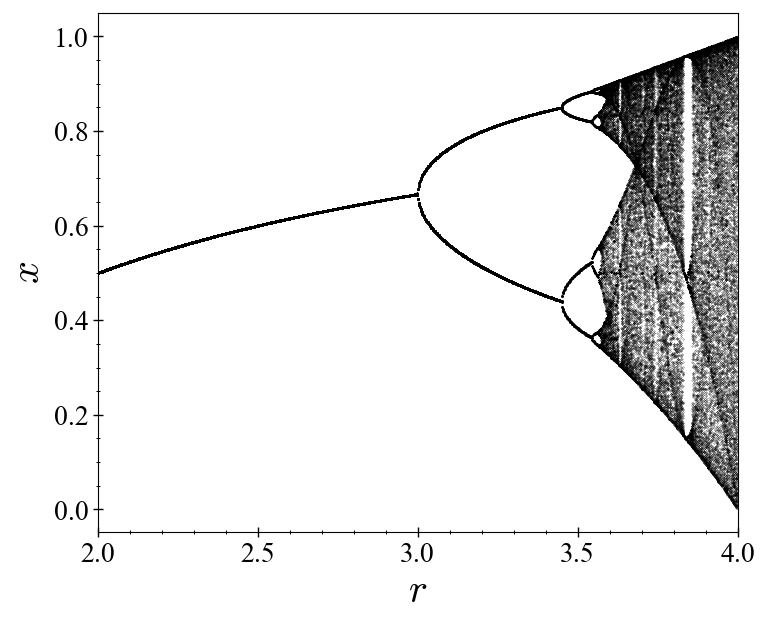

In [83]:
function bf(pvalues, n, Ttr)
    logi = Systems.logistic()
    output = orbitdiagram(logi, 1, 1, pvalues; n = n, Ttr = Ttr)

    figure(figsize=(8,6))
    for (j, p) in enumerate(pvalues)
        plot(p .* ones(output[j]), output[j], linestyle = "None", # linestyle = None
        marker = "o", ms = 0.2, color = "black")
    end
    xlabel("\$r\$"); ylabel("\$x\$");
    xlim(pvalues[1], pvalues[end])
    # ylim(0, 1)
    return 
end

bf(linspace(2.0, 4.0, 1000), 200, 2000) # all time is spend in plotting.

In [84]:
# How much time does it take?
using BenchmarkTools
@btime output = orbitdiagram(ds, i, p_index, pvalues; n = n, Ttr = Ttr);
println("for total points: $(length(pvalues)*(Ttr+n)), out of which $(length(pvalues)*n) are saved")

  32.262 ms (2011 allocations: 1.05 MiB)
for total points: 10105050, out of which 100050 are saved


---

## `orbitdiagram` works with *any* discrete system.

For demonstration, I'll use the standard map, a two-dimensional system:
$$
\begin{aligned}
\theta_{n+1} &= \theta_n + p_{n+1} \\
p_{n+1} &= p_n + k\sin(\theta_n)
\end{aligned}
$$

In [85]:
# Calculate phase-space of standard map at k = 1
ds = Systems.standardmap(k = 1.0)
r = 0:0.5:2π

# Create empty dataset
smpoints = Dataset{2, Float64}()
n = 1000

# Start collecting trajectories
for θ ∈ r
    for p ∈ r
        # Append each trajectory to the dataset:
        append!(smpoints, trajectory(ds, n, SVector(θ, p)))
    end
end

length(smpoints)

169169

In [86]:
# Get orbit diagram of standard map, for the momentum
i = 2 # second variable is the momentum
pvalues = 0.4:0.01:1.2
n = 10000
Ttr = 10000
# Use many initial conditions around (0,0):
ics = [0.001rand(2) for m in 1:4]
output = orbitdiagram(ds, i, 1, pvalues; n = n, Ttr = Ttr, ics = ics)

println(typeof(output))
println(length(output))

Array{Array{Float64,1},1}
81


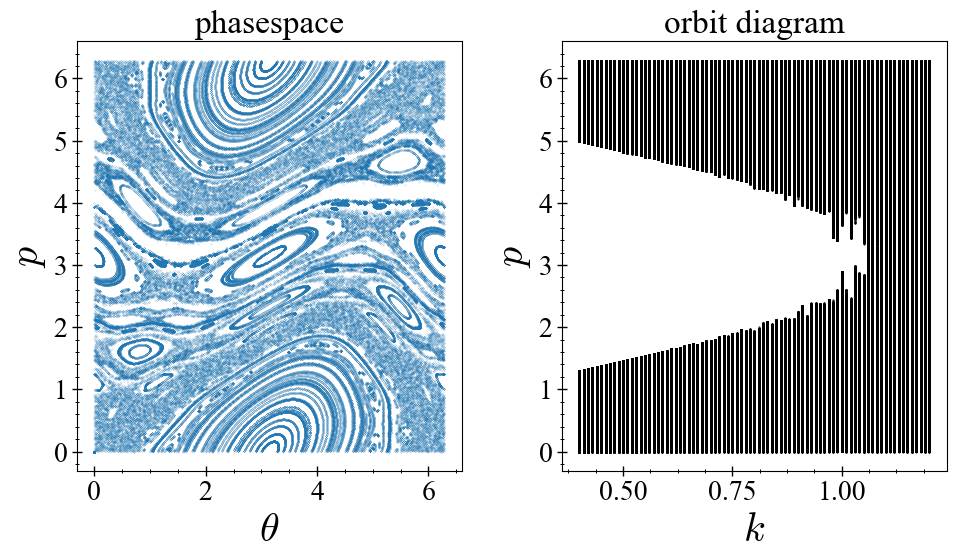

In [87]:
# Plot phase space and orbit diagram!
figure(figsize = (10,6))
subplot(121)
θ, p = columns(smpoints)
plot(θ, p, ls = "None", marker = "o", ms = 0.1)
xlabel("\$\\theta\$"); ylabel("\$p\$");
title("phasespace")

subplot(122)
for (j, p) in enumerate(pvalues)
    plot(p .* ones(output[j]), output[j], ls = "None",
    marker = "o", ms = 0.5, color = "black")
end
title("orbit diagram")
xlabel("\$k\$"); ylabel("\$p\$");
tight_layout();

* If you are familiar with the Standard Map, then you can understand that what we see on the right plot is actually the golden torus breaking.

# Poincaré Surface of Section
This is is a
technique to reduce a continuous system into a discrete map with 1 less dimension.
The wikipedia entry on [Poincaré map](https://en.wikipedia.org/wiki/Poincar%C3%A9_map) has a lot of useful info, but the technique itself is very simple:

1. Define a hyperplane, for the `j`th variable of the system. The hyper-plane is simply the plane where `state[j] = offset`, where `offset` is a constant number.
2. Evolve the continuous system for long times. Each time the trajectory crosses this plane, record the state of the system.
3. Only crossings with a specific `direction` (either positive or negative) are allowed.

And that's it! The recorded crossings are the Poincaré Surface of Section!

---

Here is the call signature for a function that does this:

```julia
poincaresos(continuous_system, j, tfinal = 100.0; offset = 0.0, direction = 1, ...)
```
which finds the surface crossings of the `j` variable

In [88]:
# Example: PSOS of Lorenz system:
lor = Systems.lorenz()

3-dimensional continuous dynamical system
 state:     [0.0, 10.0, 0.0]
 e.o.m.:    DynamicalSystemsBase.Systems.loop
 in-place?  false
 jacobian:  DynamicalSystemsBase.Systems.loop_jac


Equations of motion of Lorenz:
$$
\begin{aligned}
\dot{X} &= \sigma(Y-X) \\
\dot{Y} &= -XZ + \rho X -Y \\
\dot{Z} &= XY - \beta Z
\end{aligned}
$$

In [89]:
psos = poincaresos(lor, 2, 2000.0) # find where 2nd variable crosses 0.0

3-dimensional Dataset{Float64} with 963 points:
  -8.09637    6.93046e-12  34.7142
  -6.40974    8.2987e-11   31.903 
 -10.2555    -5.92798e-8   38.336 
  -9.1571     6.95444e-13  36.4855
 -10.0036     2.42366e-11  37.9096
   2.05684   -9.99333e-8   23.8066
  -6.62409   -6.51474e-8   32.2622
 -10.562      4.48708e-8   38.8565
 -12.46       1.66901e-8   42.1318
   4.03465   -2.57343e-8   27.8042
  -8.94355    1.00093e-9   36.128 
  -8.97913    8.79741e-13  36.1876
  -9.14661    9.80549e-13  36.468 
   ⋮                              
   2.09724   -3.09727e-12  23.9015
  -6.73705   -9.29887e-9   32.4509
 -10.7461     7.30993e-11  39.1703
   1.10577   -5.91447e-10  21.1618
  -6.0006     7.60092e-12  31.2157
  -9.78923    7.33422e-8   37.5477
   1.09594   -1.11454e-9   21.1285
  -5.90967    3.4649e-12   31.0624
  -9.70245    2.65621e-8   37.4015
   0.735651   2.55339e-10  19.7275
  -6.3474     4.9964e-11   31.7985
 -10.1755     8.13624e-10  38.2004


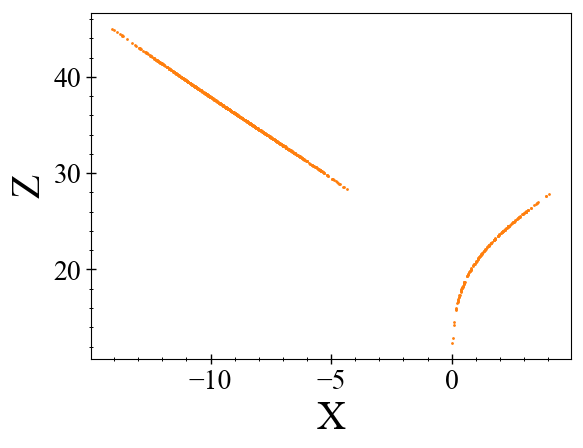

In [90]:
figure(figsize = (6,4))
plot(psos[:, 1], psos[:, 3], lw=0.0, marker ="o", ms = 1.0, color = "C1");
xlabel("X"); ylabel("Z");

* We see that the surface of section is some kind of 1-dimensional object. 
* This is expected, because as we will show in the tutorial "Entropies & Dimensions" the Lorenz system (at least for the default parameters) lives in an almost 2-dimensional attractor.

* This means that when you take a cut through this object, the result should be 1-dimensional!

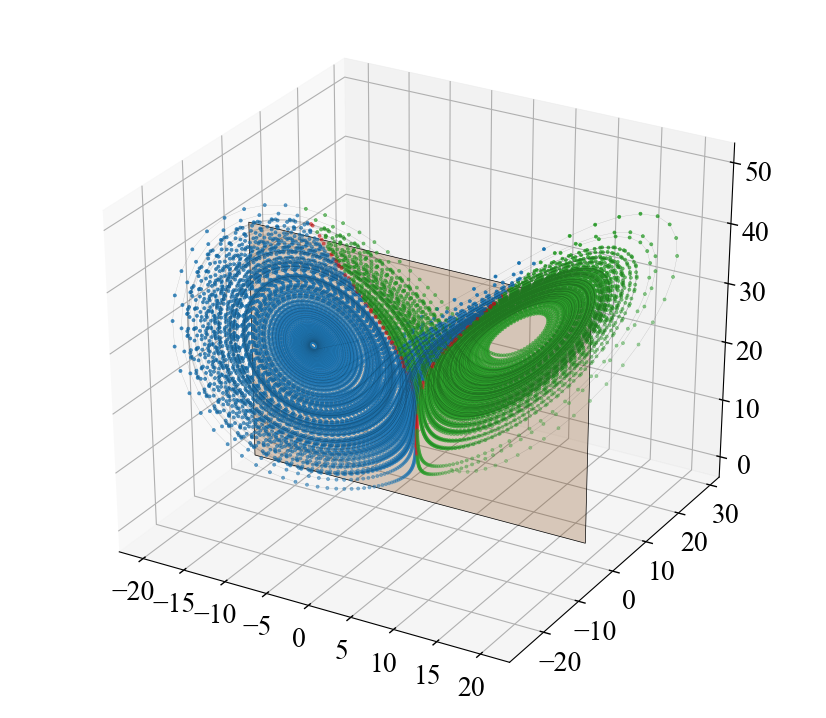

In [91]:
#Visualize the PSOS in 3D
"""
    meshgrid(x, y) -> X, Y
Create a meshgrid, such as that used in PyPlot's countrour plots.
"""
function meshgrid(vx, vy)
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    (repmat(vx, m, 1), repmat(vy, 1, n))
end


figure()

# Get attractor
tr = trajectory(lor, 200.0, dt=0.01)
x, y, z = columns(tr)

# Color points specially:
c = Vector{String}(length(y))
for i in 1:length(y) # cut points: red
    if -0.1 < y[i] < 0.1
        c[i] = "C3"
    elseif y[i] < 0 
        c[i] = "C0" # in front of cut: blue
    else
        c[i] = "C2" # behind cut: green
    end
end

# Plot attractor
plot3D(x,y,z, color = "black", lw = 0.2, alpha = 0.25)
scatter3D(x, y, z, color = c, s = 5.0)

# Plot PSOS plane:
x = [-20, 20]; z = [0, 40]; 
X, Z = meshgrid(x, z)
Y = zeros(X)

plot_surface(X, Y, Z, alpha = 0.25, color = "C1");

# Producing an orbit diagram

1. The `orbitdiagram` function does not make sense for continuous systems. In order for `orbitdiagram` to have meaning one must have a map.

2. We can take advantage of the `poincaresos` function, and reduce a continuous system to a map. 
3. Then, we can formally calculate an orbit diagram for a continuous system! 

In this example I will use the Shinriki oscillator, which displays a period-doubling route to chaos like the logistic map!

In [92]:
shinriki_voltage(V) = 2.295e-5*(exp(3.0038*V) - exp(-3.0038*V))
function shinriki_eom(u, p, t)
    R1 = p[1]

    du1 = (1/0.01)*(
    u[1]*(1/6.9 - 1/R1) - shinriki_voltage(u[1] - u[2]) - (u[1] - u[2])/14.5
    )

    du2 = (1/0.1)*(
    shinriki_voltage(u[1] - u[2]) + (u[1] - u[2])/14.5 - u[3]
    )

    du3 = (1/0.32)*(-u[3]*0.1 + u[2])
    return SVector{3}(du1, du2, du3)
end

# Be sure to give a mutable container for the parameter container!
shi = ContinuousDynamicalSystem(shinriki_eom, [-2, 0, 0.2], [22.0])

3-dimensional continuous dynamical system
 state:     [-2.0, 0.0, 0.2]
 e.o.m.:    shinriki_eom
 in-place?  false
 jacobian:  ForwardDiff


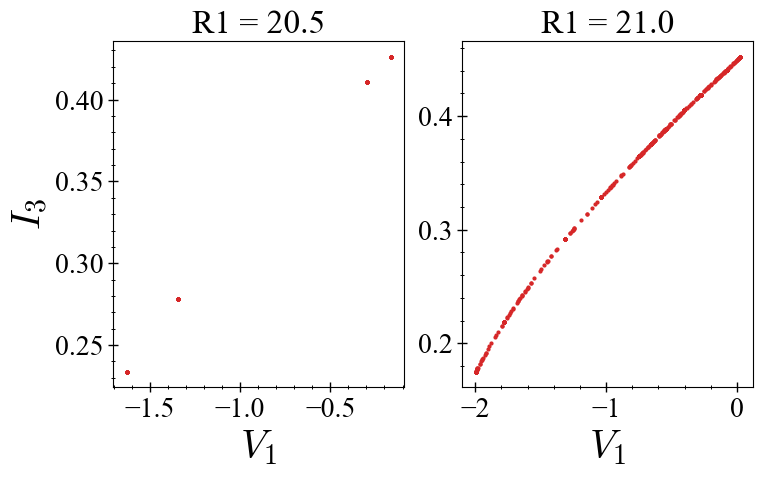

In [93]:
# Get some poicaresos to get a feeling for the system
figure(figsize=(8,4))
subplot(1,2,1)
# the function set_parameter! is useful here! (see docstring!)
R1 = 20.5
set_parameter!(shi, 1, R1)

psos = poincaresos(shi, 2, 1000.0, Ttr = 100.0, direction = -1)
plot(psos[:, 1], psos[:, 3], lw=0.0, marker ="o", ms = 2.0, color = "C3");
xlabel("\$V_1\$"); ylabel("\$I_3\$")
title("R1 = $R1")

R1 = 21.0
set_parameter!(shi, 1, R1)
subplot(1,2,2)
psos = poincaresos(shi, 2, 1000.0, Ttr = 100.0, direction = -1)
plot(psos[:, 1], psos[:, 3], lw=0.0, marker ="o", ms = 2.0, color = "C3");
xlabel("\$V_1\$"); 
title("R1 = $R1");

Hm, this is interesting! 
1. For some parameters the motion is clearly periodic (due to the distinct number of points)
2. But at other parameters the motion seems to be on a 2-dimensional manifold. 
3. *Seems to be*.

**Don't be too quick to judge the second as chaotic though! In the next tutorial "Quantifying Chaos" I will show you tools to quantify chaotic behavior!**

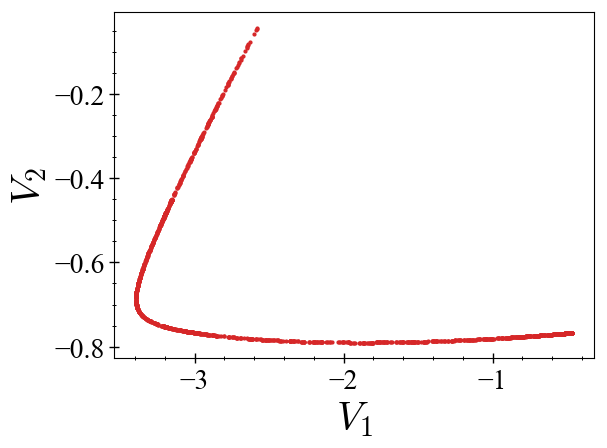

In [94]:
# One final example, taking a cut through a different hyper-plane:
figure(figsize = (6,4))

set_parameter!(shi, 1, 22.0)
psos = poincaresos(shi, 3, 2000.0; Ttr = 100.0, direction = -1)
plot(psos[:, 1], psos[:, 2], lw=0.0, marker ="o", ms = 2.0, color = "C3");
xlabel("\$V_1\$"); ylabel("\$V_2\$");

---

* Anyway, we would like to see the behavior of the system while varying the parameter, like an orbit diagram.

* We can do this by performing successive surfaces of section and then recording the values of a chosen variable!

This procedure is bundled in the very convenient function `produce_orbitdiagram`:

```julia
produce_orbitdiagram(continuous_system, j, i, p_index, pvalues; kwargs...)
```

The function produces successive `poincaresos` for the `j` variable, and records the values of the `i` variable at the section. 

Most other arguments are simply propagated to `poincaresos`.

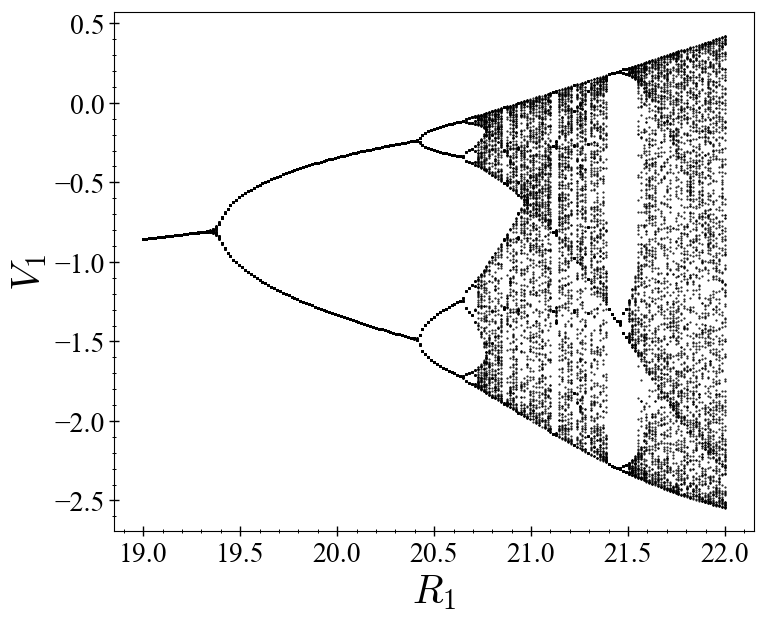

In [95]:
# Lets use this function for the Shinriki oscillator example:
# NOTE: This computation takes some seconds, since it makes 201 PSOS!

pvalues = linspace(19,22,201) # which parameter values to use
p_index = 1 # which parameter to change

i = 1       # record 1st variable
j = 2       # find PSOS of 2nd variable
tf = 200.0  # argument passed to poincaresos

output = produce_orbitdiagram(shi, j, i, p_index, pvalues; 
                              # all keywords are passed to poincaresos:
                              tfinal = tf, Ttr = 200.0, direction = -1)

figure(figsize=(8,6))
for (j, p) in enumerate(pvalues)
    plot(p .* ones(output[j]), output[j], ls = "None",
    marker = "o", ms = 0.5, color = "black")
end
xlabel("\$R_1\$"); ylabel("\$V_1\$");

* woooooooooooooooooooooooooooo period doubling!!!

---

One more example, using the Gissinger system:

$$
\begin{aligned}
\dot{Q} &= \mu Q - VD \\
\dot{D} &= -\nu D + VQ \\
\dot{V} &= \Gamma -V + QD
\end{aligned}
$$


In [96]:
gis = Systems.gissinger()

3-dimensional continuous dynamical system
 state:     [0.314765, 1.15699, 2.00177]
 e.o.m.:    DynamicalSystemsBase.Systems.gissinger_eom
 in-place?  false
 jacobian:  ForwardDiff


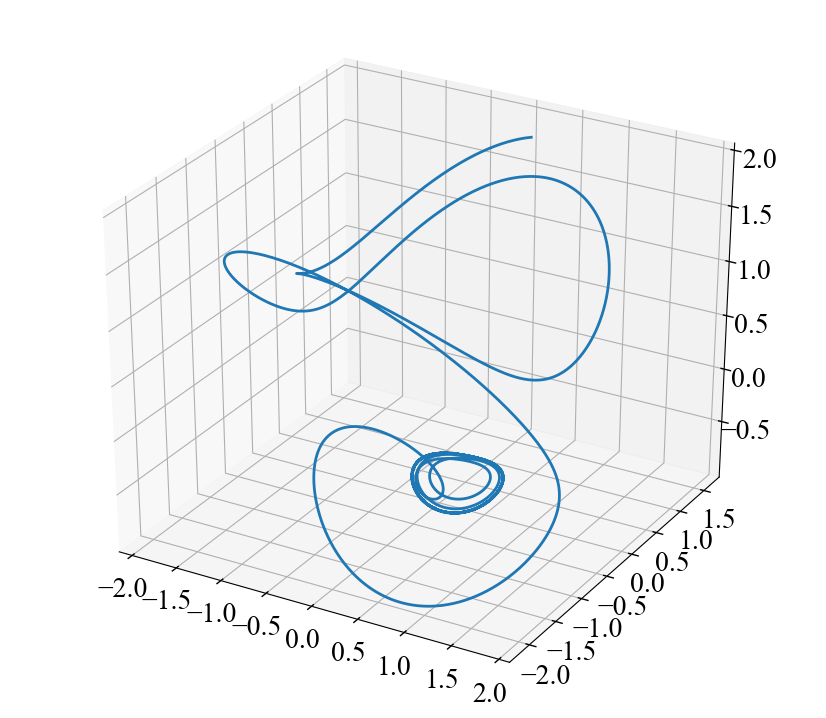

In [97]:
set_parameter!(gis, 1, 0.15)
tr = trajectory(gis, 100.0)

plot3D(columns(tr)...);

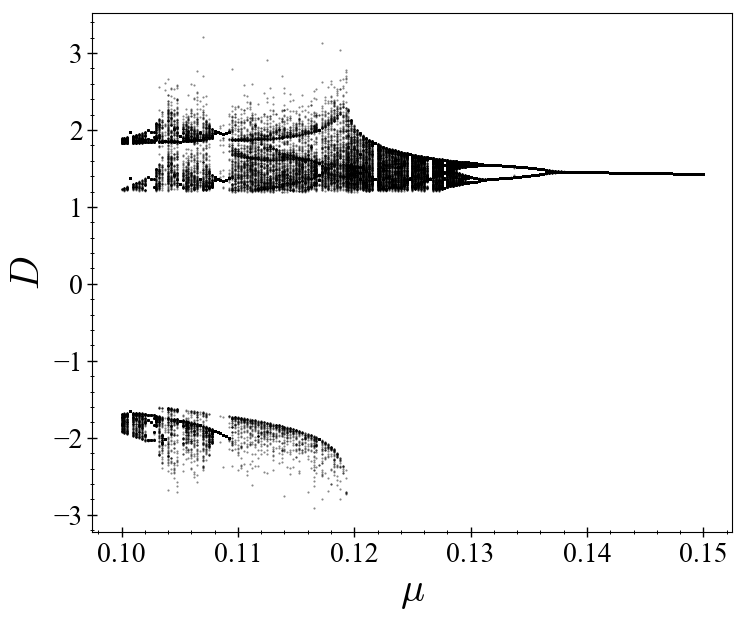

In [98]:
pvalues = linspace(0.1,0.15,201) # which parameter values to use
p_index = 1 # change 2nd parameter, which is μ

i = 2            # record i variable
j = 1            # find PSOS of j variable
offset = -0.75   # offset is important here

tf = 4000.0 
ics = [[2.32865, 2.02514, 1.98312]]

output = produce_orbitdiagram(gis, j, i, p_index, pvalues; ics = ics,
                              # all keywords are passed to poincaresos:
                              tfinal = tf, Ttr = 200.0, offset = offset)

figure(figsize=(8,6))
for (j, p) in enumerate(pvalues)
    plot(p .* ones(output[j]), output[j], ls = "None",
    marker = "o", ms = 0.5, color = "black", alpha = 0.5)
end
xlabel("\$\\mu\$"); ylabel("\$D\$");

# Docstrings

In [99]:
?orbitdiagram

search: orbitdiagram produce_orbitdiagram



```
orbitdiagram(ds::DiscreteDynamicalSystem, i, p_index, pvalues; kwargs...)
```

Compute the orbit diagram (also called bifurcation diagram) of the given system for the `i`-th variable for parameter values `pvalues`. The `p_index` specifies which parameter of the equations of motion is to be changed.

Returns a vector of vectors, where each entry are the points are each parameter value.

## Keyword Arguments

  * `ics = [state(ds)]` : container of initial conditions that are used at each parameter value to evolve orbits.
  * `Ttr::Int = 1000` : Transient steps; each orbit is evolved for `Ttr` first before saving output.
  * `n::Int = 100` : Amount of points to save for each initial condition.

## Description

The method works by computing orbits at each parameter value in `pvalues` for each initial condition in `ics`.

The parameter change is done as `p[p_index] = ...` and thus you must use a parameter container that supports this (either `Array`, `LMArray`, dictionary or other).

The returned `output` is a vector of vectors. `output[j]` are the orbit points of the `i`-th variable of the system, at parameter value `pvalues[j]`.

See also [`poincaresos`](@ref) and [`produce_orbitdiagram`](@ref).


In [100]:
?poincaresos

search: poincaresos



```
poincaresos(ds::ContinuousDynamicalSystem, j, tfinal = 100.0; kwargs...)
```

Calculate the Poincaré surface of section (also called Poincaré map) [1, 2] of the given system on the plane of the `j`-th variable of the system. The system is evolved for total time of `tfinal`.

Returns a [`Dataset`](@ref) of the points that are on the surface of section.

## Keyword Arguments

  * `direction = 1` and `offset = 0.0` : The surface of section is defined as the (hyper-) plane where `state[j] = offset`. Only crossings of the plane that have direction `sign(direction)` are considered to belong to the surface of section.
  * `Ttr = 0.0` : Transient time to evolve the system before starting to compute the PSOS.
  * `diff_eq_kwargs` : See [`trajectory`](@ref).
  * `callback_kwargs = Dict(:abstol=>1e-6)` : Keyword arguments passed into the `ContinuousCallback` type of `DifferentialEquations`, used to find the section. The option `callback_kwargs[:idxs] = j` is enforced. Decreasing the `abstol` makes the section more accurate.

## References

[1] : H. Poincaré, *Les Methods Nouvelles de la Mécanique Celeste*, Paris: Gauthier-Villars (1892)

[2] : M. Tabor, *Chaos and Integrability in Nonlinear Dynamics: An Introduction*, §4.1, in pp. 118-126, New York: Wiley (1989)

See also [`orbitdiagram`](@ref), [`produce_orbitdiagram`](@ref).


In [101]:
?produce_orbitdiagram

search: produce_orbitdiagram



```
produce_orbitdiagram(ds::ContinuousDynamicalSystem, j, i,
                     p_index, pvalues; kwargs...)
```

Produce an orbit diagram (also called bifurcation diagram) for the `i`-th variable of the given continuous system by computing Poincaré surfaces of section of the `j`-th variable of the system for the given parameter values.

## Keyword Arguments

  * `direction`, `offset`, `diff_eq_kwargs`, `callback_kwargs`, `Ttr` : Passed into [`poincaresos`](@ref).
  * `printparams::Bool = false` : Whether to print the parameter used during computation in order to keep track of running time.
  * `ics = [state(ds)]` : Collection of initial conditions. For every `state ∈ ics` a PSOS will be produced.

## Description

For each parameter, a PSOS reduces the system from a flow to a map. This then allows the formal computation of an "orbit diagram" for one of the `i ≠ j` variables of the system, just like it is done in [`orbitdiagram`](@ref).

The parameter change is done as `p[p_index] = value` taking values from `pvalues` and thus you must use a parameter container that supports this (either `Array`, `LMArray`, dictionary or other).

The returned `output` is a vector of vectors. `output[k]` are the "orbit diagram" points of the `i`-th variable of the system, at parameter value `pvalues[k]`.

## Performance Notes

The total amount of PSOS produced will be `length(ics)*length(pvalues)`.

See also [`poincaresos`](@ref), [`orbitdiagram`](@ref).
